In [57]:
import mne
import numpy as np
import mne
import numpy as np
import os
import pandas as pd
from pathlib import Path

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup

# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data

import warnings
warnings.filterwarnings("ignore")

# Use neurodsp for convenience
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.spectral import compute_spectrum

# KNEE freqs
from fooof.utils.params import compute_knee_frequency

# Plotting functions
import matplotlib.pyplot as plt
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
import imagesc as imagesc

# Load Paths

In [6]:
# PATHS
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)

# Settings

In [18]:
SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean' }
SETTINGS_F1 = {'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2 = {'max_n_peaks':8, 'aperiodic_mode':'fixed'}
fs = 128
electrode = 'E257'

# Freq limits

In [8]:
# Time parametres for broadband analysis
Time_segments = [ 5,  10, 15, 20] # seconds
f_min = [1,1,1,1, 1, 1 , 20, 30] # Hz
f_max = [30,45,75,100,8, 20 , 45, 45] # Hz

# Empty Matrices

In [45]:
A= np.zeros([17,4,8])*np.nan
B= np.zeros([17,4,8])*np.nan
C= np.zeros([17,4,8])*np.nan
D= np.zeros([17,4,8])*np.nan
E= np.zeros([17,4,8])*np.nan

Ar= np.zeros([17,4,8])*np.nan
Br= np.zeros([17,4,8])*np.nan
Cr= np.zeros([17,4,8])*np.nan
Dr= np.zeros([17,4,8])*np.nan
Er= np.zeros([17,4,8])*np.nan 

F= np.zeros([17,4,8])*np.nan
G= np.zeros([17,4,8])*np.nan
H= np.zeros([17,4,8])*np.nan
J= np.zeros([17,4,8])*np.nan
K= np.zeros([17,4,8])*np.nan

Fr= np.zeros([17,4,8])*np.nan
Gr= np.zeros([17,4,8])*np.nan
Hr= np.zeros([17,4,8])*np.nan
Jr= np.zeros([17,4,8])*np.nan
Kr= np.zeros([17,4,8])*np.nan

# LOADING EEG DATA

In [46]:
# Start function
i = 0
for x in subj_files:
    #check_path(path_results / x[0:4]) # create subject folder
    EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
    print('loaded')
    EEG = EEG.pick(electrode, exclude=[]) # select Cz for further analysis
    
    events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers
    epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)
#Now we select epochs and average over all epochs
    N1s = epochs['1']
    N2s = epochs['2']
    N3s = epochs['3']
    REs = epochs['5']
    AWs = epochs['0']
    
    
# Settings for PSD calculation using welch's
    N1={}
    N2={}
    N3={}
    AW={}
    RM={}
    
    ii = 0
    for t in Time_segments:
        
        iii = 0
        for xx in np.arange(len(f_min)):
        # calculate psd based on welch's method with differen freq range and diff time steps
            N1 = N1s.compute_psd(**SETTINGS_W, fmin=f_min[xx], fmax=f_max[xx], n_fft=fs*t, n_overlap=fs*t*0.5) #N1
            N2 = N2s.compute_psd(**SETTINGS_W, fmin=f_min[xx], fmax=f_max[xx], n_fft=fs*t, n_overlap=fs*t*0.5) #N2
            N3 = N3s.compute_psd(**SETTINGS_W, fmin=f_min[xx], fmax=f_max[xx], n_fft=fs*t, n_overlap=fs*t*0.5)
            AW = AWs.compute_psd(**SETTINGS_W, fmin=f_min[xx], fmax=f_max[xx], n_fft=fs*t, n_overlap=fs*t*0.5)
            RM = REs.compute_psd(**SETTINGS_W, fmin=f_min[xx], fmax=f_max[xx], n_fft=fs*t, n_overlap=fs*t*0.5)


        # FOOOF it 
        # KNEE
            fm1 = FOOOFGroup(**SETTINGS_F1)
            fm1.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])

            fm2 = FOOOFGroup(**SETTINGS_F1)
            fm2.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])

            fm3 = FOOOFGroup(**SETTINGS_F1)
            fm3.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])

            fm4 = FOOOFGroup(**SETTINGS_F1)
            fm4.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])

            fm5 = FOOOFGroup(**SETTINGS_F1)
            fm5.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])

        # FIXED
            fm6 = FOOOFGroup(**SETTINGS_F2)
            fm6.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])

            fm7 = FOOOFGroup(**SETTINGS_F2)
            fm7.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])

            fm8 = FOOOFGroup(**SETTINGS_F2)
            fm8.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])

            fm9 = FOOOFGroup(**SETTINGS_F2)
            fm9.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])

            fm10 = FOOOFGroup(**SETTINGS_F2)
            fm10.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])


        # parameters exctraction
            A[i,ii,iii] = fm10.get_params('aperiodic_params','exponent')
            B[i,ii,iii] = fm6.get_params('aperiodic_params','exponent')
            C[i,ii,iii] = fm7.get_params('aperiodic_params','exponent')
            D[i,ii,iii] = fm8.get_params('aperiodic_params','exponent')
            E[i,ii,iii] = fm9.get_params('aperiodic_params','exponent') 

            Ar[i,ii,iii] = fm10.get_params('r_squared')
            Br[i,ii,iii] = fm6.get_params('r_squared')
            Cr[i,ii,iii] = fm7.get_params('r_squared')
            Dr[i,ii,iii] = fm8.get_params('r_squared')
            Er[i,ii,iii] = fm9.get_params('r_squared') 

            
            F[i,ii,iii] = fm5.get_params('aperiodic_params','exponent')
            G[i,ii,iii] = fm1.get_params('aperiodic_params','exponent')
            H[i,ii,iii] = fm2.get_params('aperiodic_params','exponent')
            J[i,ii,iii] = fm3.get_params('aperiodic_params','exponent')
            K[i,ii,iii] = fm4.get_params('aperiodic_params','exponent') 

            Fr[i,ii,iii] = fm5.get_params('r_squared')
            Gr[i,ii,iii] = fm1.get_params('r_squared')
            Hr[i,ii,iii] = fm2.get_params('r_squared')
            Jr[i,ii,iii] = fm3.get_params('r_squared')
            Kr[i,ii,iii] = fm4.get_params('r_squared') 
            
            iii = iii + 1
            
        ii = ii +1
            
    i = i + 1    
            

loaded
Not setting metadata
927 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 85 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Using data from preloaded Raw for 75 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 2.560 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below fre

Using data from preloaded Raw for 85 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 74 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 85 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
Effective window si

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Effective window size : 5.120 (s)
Using data from preloaded Raw for 74 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 85 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
Effecti

Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 85 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 74 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
Effecti

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 85 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 74 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Ru

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Effective window size : 2.560 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 215 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 215 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 5.120 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 215 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 38 events and 7501 original time points ...
Effect

Using data from preloaded Raw for 215 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 38 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using 

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 38 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 276 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 344 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 215 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 103 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
R

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 352 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 223 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 218 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 176 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Runnin

Effective window size : 7.680 (s)
Using data from preloaded Raw for 352 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 223 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 218 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 176 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effect

Using data from preloaded Raw for 218 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 176 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 352 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 223 events and 7501 original time points ...
Effective window size : 10.240 (s)
U

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window si

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 242 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 148 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window si

Effective window size : 5.120 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 242 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 148 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effecti

Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 148 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 242 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using d

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 390 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 242 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 148 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Ru

Effective window size : 2.560 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using d

Using data from preloaded Raw for 192 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 229 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 383 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 95 events and 7501 original time points ...
Effective window size : 10.240 (s)
Us

Effective window size : 2.560 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra

Effective window size : 2.560 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Runnin

Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using 

Using data from preloaded Raw for 155 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 127 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 78 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 328 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 278 events and 7501 original time points ...
Effective window size : 10.240 (s)
U

Effective window size : 2.560 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Using data from preloaded Raw for 77 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 77 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Runnin

Effective window size : 7.680 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 77 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effect

Effective window size : 10.240 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 77 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 443 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 174 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
E

Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

Effective window size : 2.560 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Effective window size : 7.680 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effecti

Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 313 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 71 events and 7501 original time points ...
Effective window size : 10.240 (s)
Us

Effective window size : 2.560 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 61 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Effective window size : 7.680 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 61 events and 7501 original time points ...
Effecti

Using data from preloaded Raw for 62 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 184 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 61 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
Effective window size : 10.240 (s)
Us

Effective window size : 2.560 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 19 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 19 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effect

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 19 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Runnin

Effective window size : 10.240 (s)
Using data from preloaded Raw for 220 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 250 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 252 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 19 events and 7501 original time points ...
E

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Effective window size : 2.560 (s)
Using data from preloaded Raw for 207 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 29 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resoluti

Effective window size : 2.560 (s)
Using data from preloaded Raw for 207 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 29 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resoluti

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 207 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 29 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running 

Using data from preloaded Raw for 207 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 29 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using da

Effective window size : 10.240 (s)
Using data from preloaded Raw for 94 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 207 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 255 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 29 events and 7501 original time points ...
Eff

Effective window size : 2.560 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 63 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 63 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using d

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 63 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 63 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 316 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 348 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 48 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 188 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Ru

Effective window size : 2.560 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Model fitting was unsuccessful.
Running FO

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Effective window size : 10.240 (s)
Using data from preloaded Raw for 227 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 50 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 289 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 44 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 345 events and 7501 original time points ...
Ef

Effective window size : 2.560 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using d

Effective window size : 10.240 (s)
Using data from preloaded Raw for 21 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 213 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 72 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 349 events and 7501 original time points ...
Ef

Using data from preloaded Raw for 116 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra

Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 116 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra

Effective window size : 5.120 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 116 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effect

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 116 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 7.680 (s)
Runnin

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 116 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 357 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 343 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 37 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 146 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
R

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 41 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window si

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Effective window size : 2.560 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 53 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Effective window size : 2.560 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 53 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolut

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 41 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 53 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running

Effective window size : 7.680 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 53 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 41 events and 7501 original time points ...
Effecti

Using data from preloaded Raw for 53 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 41 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 319 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
Effective window size : 10.240 (s)
Us

Using data from preloaded Raw for 113 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectr

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Using data from preloaded Raw for 113 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectr

Effective window size : 2.560 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Effective window size : 2.560 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 2.560 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 2.560 (s)
Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.39 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolu

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 113 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 5.120 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 5.120 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Runni

Effective window size : 7.680 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 7.680 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 7.680 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 113 events and 7501 original time points ...
Effec

Effective window size : 10.240 (s)
Using data from preloaded Raw for 162 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 101 events and 7501 original time points ...
Effective window size : 10.240 (s)
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Using data from preloaded Raw for 113 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 322 events and 7501 original time points ...
Effective window size : 10.240 (s)
Using data from preloaded Raw for 292 events and 7501 original time points ...


# EXPONENT

## Fixed

In [67]:
Am = np.nanmean(A,0)
W_BB=Am[:,0:4]
W_NB=Am[:,4:8]

Bm = np.nanmean(B,0)
N1_BB=Bm[:,0:4]
N1_NB=Bm[:,4:8]

Cm = np.nanmean(C,0)
N2_BB=Cm[:,0:4]
N2_NB=Cm[:,4:8]

Dm = np.nanmean(D,0)
N3_BB=Dm[:,0:4]
N3_NB=Dm[:,4:8]

Em = np.nanmean(E,0)
R_BB=Em[:,0:4]
R_NB=Em[:,4:8]

# now we can mean over stages 
Exp_Broad = np.nanmean([W_BB, N1_BB, N2_BB, N3_BB, R_BB],0)
Exp_Narrow = np.nanmean([W_NB, N1_NB, N2_NB, N3_NB, R_NB],0)

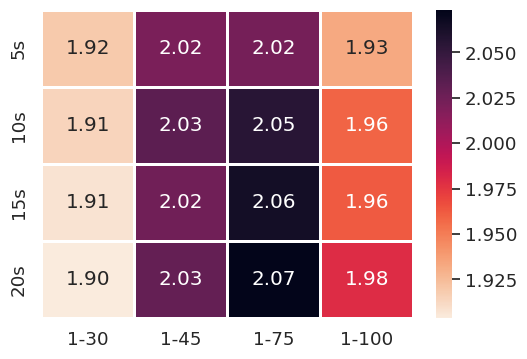

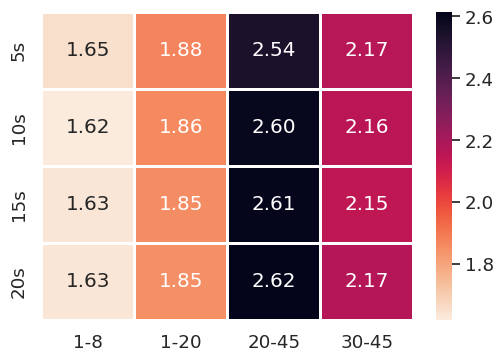

In [68]:
# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(Exp_Broad,columns=['1-30', '1-45','1-75','1-100'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_BB_Fixed_Exp.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(Exp_Narrow,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_NB_Fixed_Exp.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

## Knee M

In [62]:
Fm = np.nanmean(F,0)
W_BB_K=Fm[:,0:4]
W_NB_K=Fm[:,4:8]

Gm = np.nanmean(G,0)
N1_BB_K=Gm[:,0:4]
N1_NB_K=Gm[:,4:8]

Hm = np.nanmean(H,0)
N2_BB_K=Hm[:,0:4]
N2_NB_K=Hm[:,4:8]

Jm = np.nanmean(J,0)
N3_BB_K=Jm[:,0:4]
N3_NB_K=Jm[:,4:8]

Km = np.nanmean(K,0)
R_BB_K=Km[:,0:4]
R_NB_K=Km[:,4:8]

# now we can mean over stages 
Exp_Broad = np.nanmean([W_BB_K,N1_BB_K,N2_BB_K,N3_BB_K,R_BB_K],0)
Exp_narrow = np.nanmean([W_NB_K,N1_NB_K,N2_NB_K,N3_NB_K,R_NB_K],0)

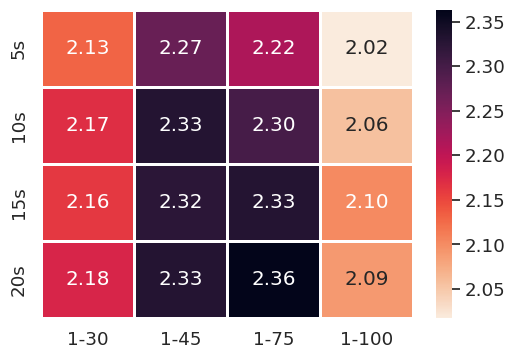

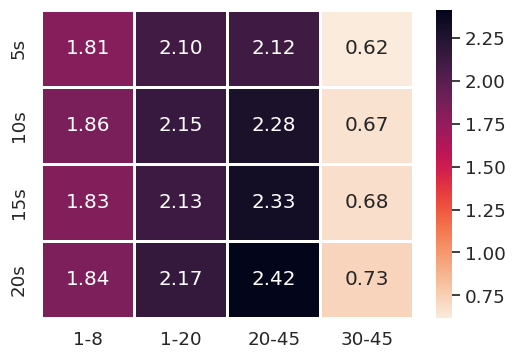

In [64]:
# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(Exp_Broad,columns=['1-30', '1-45','1-75','1-100'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_BB_Knee_Exp.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(Exp_narrow,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_NB_Knee_Exp.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

# R2

In [70]:
Am = np.nanmean(Ar,0)
W_BB=Am[:,0:4]
W_NB=Am[:,4:8]

Bm = np.nanmean(Br,0)
N1_BB=Bm[:,0:4]
N1_NB=Bm[:,4:8]

Cm = np.nanmean(Cr,0)
N2_BB=Cm[:,0:4]
N2_NB=Cm[:,4:8]

Dm = np.nanmean(Dr,0)
N3_BB=Dm[:,0:4]
N3_NB=Dm[:,4:8]

Em = np.nanmean(Er,0)
R_BB=Em[:,0:4]
R_NB=Em[:,4:8]

# now we can mean over stages 
R_Broad = np.nanmean([W_BB, N1_BB, N2_BB, N3_BB, R_BB],0)
R_Narrow = np.nanmean([W_NB, N1_NB, N2_NB, N3_NB, R_NB],0)

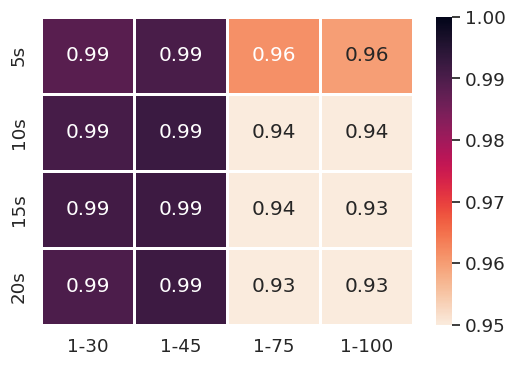

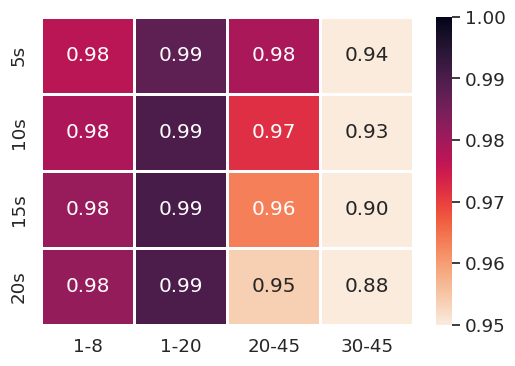

In [71]:
# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(R_Broad,columns=['1-30', '1-45','1-75','1-100'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_BB_Fixed_R2.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(R_Narrow,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1, vmin=0.95, vmax=1.0)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_NB_Fixed_R2.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

## KNEE

In [73]:
Fm = np.nanmean(Fr,0)
W_BB_K=Fm[:,0:4]
W_NB_K=Fm[:,4:8]

Gm = np.nanmean(Gr,0)
N1_BB_K=Gm[:,0:4]
N1_NB_K=Gm[:,4:8]

Hm = np.nanmean(Hr,0)
N2_BB_K=Hm[:,0:4]
N2_NB_K=Hm[:,4:8]

Jm = np.nanmean(Jr,0)
N3_BB_K=Jm[:,0:4]
N3_NB_K=Jm[:,4:8]

Km = np.nanmean(Kr,0)
R_BB_K=Km[:,0:4]
R_NB_K=Km[:,4:8]

# now we can mean over stages 
R2_Broad = np.nanmean([W_BB_K,N1_BB_K,N2_BB_K,N3_BB_K,R_BB_K],0)
R2_narrow = np.nanmean([W_NB_K,N1_NB_K,N2_NB_K,N3_NB_K,R_NB_K],0)

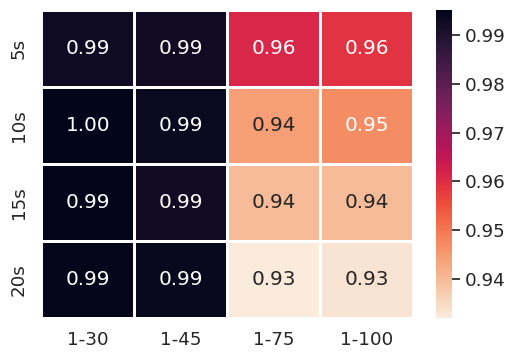

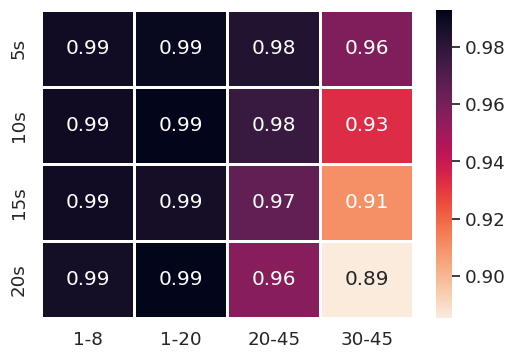

In [74]:
# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(R2_Broad,columns=['1-30', '1-45','1-75','1-100'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_BB_Knee_R2.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))

# Now the arrays are ready for plotting 
plt.figure(figsize=(6, 4))
data_s = pd.DataFrame(R2_narrow,columns=['1-8', '1-20','20-45','30-45'], index=['5s','10s','15s', '20s'])
sns.heatmap(data_s,  annot=True, cmap='rocket_r', fmt='.2f', linewidths=1)
sns.set(font_scale=1.2)
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/EEG_Sensitivity_NB_Knee_R2.svg')
#R2_all_finalN = np.reshape(R2_allN, (4, 4))